# Practice notebook for confidence intervals using NHANES data

This notebook will give you the opportunity to practice working with confidence intervals using the NHANES data.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

da = pd.read_csv("nhanes_2015_2016.csv")

## Question 1

Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [2]:
# enter your code here
df_women35to50 = da[(da['RIDAGEYR']>=35) & (da['RIDAGEYR']<=50) & (da['RIAGENDR']==2)].copy()
#df_women35to50['Married'] = 1
df_women35to50['Married'] = np.where(df_women35to50['DMDMARTL']==1,1,0)
#df_women35to50['CompletedCollege'] = 1
df_women35to50['CompletedCollege'] = np.where(df_women35to50['DMDEDUC2']==5,1,0)
df_women35to50 = df_women35to50[['Married','CompletedCollege','RIDAGEYR']]
df_women35to50.head(5)

,Married,CompletedCollege,RIDAGEYR
4,0,0,42
34,1,0,37
50,1,0,39
52,0,0,50
55,1,0,45


In [3]:
df_prop = df_women35to50
df_prop['Married'].replace({0:'Not married',1:'Married'},inplace=True)
df_prop = df_women35to50.groupby('Married').agg({'CompletedCollege':[np.mean,np.size]})
df_prop.rename(columns={'mean':'Proportion','size':'N'},inplace=True)
df_prop.index.name=None
df_prop

CompletedCollege     
                  Proportion    N
Married             0.360802  449
Not married         0.213018  338

In [4]:
print('Married interval: ',sm.stats.proportion_confint(df_prop.iloc[0,0]*df_prop.iloc[0,1], df_prop.iloc[0,1]))
print('Not Married interval: ',sm.stats.proportion_confint(df_prop.iloc[1,0]*df_prop.iloc[1,1], df_prop.iloc[1,1]))

Married interval:  (0.31638193710753626, 0.4052216263668512)
Not Married interval:  (0.16936816767089768, 0.2566673352876822)


__Q1a.__ Identify which of the two confidence intervals is wider, and explain why this is the case. 

__Q1b.__ Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

## Question 2

Construct 95% confidence intervals for the proportion of smokers who are female, and for the proportion of smokers who are male.  Then construct a 95% confidence interval for the difference between these proportions.

In [5]:
df_smokers = da[['SMQ020','RIAGENDR']].copy()
df_smokers['Smoker'] = np.where(df_smokers['SMQ020']==1,1,0)
df_smokers['Gender'] = np.where(df_smokers['RIAGENDR']==1,'Male','Female')
df_smokers.drop(columns=['SMQ020','RIAGENDR'],inplace=True)
ct_smokers = pd.crosstab(df_smokers['Smoker'],df_smokers['Gender'])
ct_smokers

Gender,Female,Male
Smoker,,
0,2070,1346
1,906,1413


In [6]:
n_male = ct_smokers.loc[1,'Male']+ct_smokers.loc[0,'Male']
p_male = ct_smokers.loc[1,'Male']/n_male

n_female = ct_smokers.loc[1,'Female']+ct_smokers.loc[0,'Female']
p_female = ct_smokers.loc[1,'Female']/n_female

print('Proportion of Male Smokers:\t\t ','(%.3f)' %(p_male))

print('Proportion of Male Smokers CI:\t\t ','(%.3f , %.3f)' %sm.stats.proportion_confint(p_male*n_male,n_male))

print('Proportion of Female Smokers:\t\t ','(%.3f)' %p_female)

print('Proportion of Female Smokers CI:\t ','(%.3f , %.3f)' %sm.stats.proportion_confint(p_female*n_female,n_female))

Proportion of Male Smokers:		  (0.512)
Proportion of Male Smokers CI:		  (0.493 , 0.531)
Proportion of Female Smokers:		  (0.304)
Proportion of Female Smokers CI:	  (0.288 , 0.321)


In [7]:
se_male = np.sqrt(p_male*(1-p_male)/n_male)
print(se_male)

se_female = np.sqrt(p_female*(1-p_female)/n_female)
print(se_female)

se_diff = np.sqrt(se_female**2 + se_male**2)
print(se_diff)

0.009516254762527675
0.008435287344906213
0.012716649609722899


In [8]:
df_smokers[df_smokers['Gender']=='Male'].std()/np.sqrt(n_male)

Smoker    0.009518
dtype: float64

In [9]:
diff = p_male - p_female
print(diff)

lcb = diff - 1.96 * se_diff
ucb = diff + 1.96 * se_diff
(lcb,ucb)

0.20770659659296842


(0.18278196335791153, 0.2326312298280253)

In [10]:
meanCI_male = sm.stats.DescrStatsW(df_smokers[df_smokers['Gender']=='Male']['Smoker'])#.zconfint_mean()
meanCI_female = sm.stats.DescrStatsW(df_smokers[df_smokers['Gender']=='Female']['Smoker'])#.zconfint_mean()

#print(meanCI_male,'\n',meanCI_female)

sm.stats.CompareMeans(meanCI_male,meanCI_female).zconfint_diff()

(0.18285580207735627, 0.23255739110858056)

__Q2a.__ Discuss why it may be relevant to report the proportions of smokers who are female and male, and contrast this to reporting the proportions of males and females who smoke.

__Q2b.__ How does the width of the confidence interval for the difference of the two proportions compare to the widths of the confidence intervals for each proportion separately?

## Question 3

Construct a 95% interval for height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) in centimeters.  Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches.  Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters   

In [11]:
df_height = da[['BMXHT']].dropna()
print(df_height.isnull().sum())
df_height.describe()

BMXHT    0
dtype: int64


,BMXHT
count,5673.000000
mean,166.142834
std,10.079264
min,129.700000
25%,158.700000
50%,166.000000
75%,173.500000
max,202.700000


In [12]:
print(df_height['BMXHT'].mean())
sm.stats.DescrStatsW(df_height['BMXHT']).zconfint_mean()

166.14283447911131


(165.88055125872887, 166.40511769949427)

In [13]:
df_height['Inches'] = df_height['BMXHT']/2.54
print(df_height['Inches'].mean())
sm.stats.DescrStatsW(df_height['Inches']).zconfint_mean()

65.41056475555557


(65.30730364516884, 65.51382586594264)

In [14]:
print(65.30730364516884*2.54,65.51382586594264*2.54)

165.88055125872887 166.4051176994943


__Q3a.__ Describe how the confidence interval constructed in centimeters relates to the confidence interval constructed in inches.

## Question 4

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

In [38]:
da['agegrp'] = pd.cut(da['RIDAGEYR'],[18,30,40,50,60,70,80])
da['Gender'] = np.where(da['RIAGENDR']==2,'Female','Male')

In [39]:
print(da.shape)
print(da['BMXBMI'].isnull().sum())
da[['BMXBMI','Gender','agegrp']].head()

(5735, 30)
73


,BMXBMI,Gender,agegrp
0,27.8,Male,"(60, 70]"
1,30.8,Male,"(50, 60]"
2,28.8,Male,"(70, 80]"
3,42.4,Female,"(50, 60]"
4,20.3,Female,"(40, 50]"


In [40]:
df_bmi = da.copy()
df_bmi.dropna(subset=['BMXBMI'],axis=0,inplace=True)
df_bmi = df_bmi[['Gender','agegrp','BMXBMI']]
print(df_bmi.shape)
print(df_bmi['BMXBMI'].isnull().sum())
df_bmi.head()

(5662, 3)
0


,Gender,agegrp,BMXBMI
0,Male,"(60, 70]",27.8
1,Male,"(50, 60]",30.8
2,Male,"(70, 80]",28.8
3,Female,"(50, 60]",42.4
4,Female,"(40, 50]",20.3


In [41]:
df_diffints = pd.DataFrame(columns = ['agegrp','diff','difference CI'])

for j in df_bmi['agegrp'].value_counts().index:
    male = sm.stats.DescrStatsW( df_bmi[ (df_bmi['Gender']=='Male') & (df_bmi['agegrp']==j) ]['BMXBMI'] )
    female = sm.stats.DescrStatsW( df_bmi[ (df_bmi['Gender']=='Female') & (df_bmi['agegrp']==j) ]['BMXBMI'] )
    diff = -(df_bmi[ (df_bmi['Gender']=='Male') & (df_bmi['agegrp']==j) ]['BMXBMI'].mean()) + ( df_bmi[ (df_bmi['Gender']=='Female') & (df_bmi['agegrp']==j) ]['BMXBMI'].mean() )
    df_diffints = df_diffints.append(
        {'agegrp':j,
         'difference CI':sm.stats.CompareMeans(female,male).zconfint_diff(),
        'diff':diff} , ignore_index = True)
    
df_diffints[['lb','ub']] = pd.DataFrame(df_diffints['difference CI'].tolist())
df_diffints.drop(columns=['difference CI'],inplace=True)
df_diffints                                      

,agegrp,diff,lb,ub
0,"(18, 30]",0.732059,-0.110611,1.574729
1,"(30, 40]",0.713861,-0.259233,1.686954
2,"(50, 60]",1.512291,0.630691,2.393892
3,"(40, 50]",1.436019,0.463264,2.408775
4,"(60, 70]",1.682340,0.770782,2.593899
5,"(70, 80]",1.180521,0.389953,1.971089


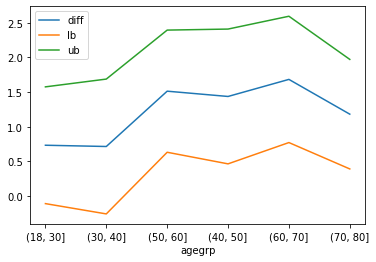

In [42]:
df_diffints.set_index('agegrp',inplace=True)
df_diffints.plot(kind='line')

__Q4a.__ How do the widths of these confidence intervals differ?  Provide an explanation for any substantial diferences in the confidence interval widths that you see.

## Question 5

Construct a 95% confidence interval for the first and second systolic blood pressure measures, and for the difference between the first and second systolic blood pressure measurements within a subject.

In [43]:
da.columns.values

array(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR',
       'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL',
       'DMDHHSIZ', 'WTINT2YR', 'SDMVPSU', 'SDMVSTRA', 'INDFMPIR',
       'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI',
       'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'HIQ210', 'agegrp',
       'Gender'], dtype=object)

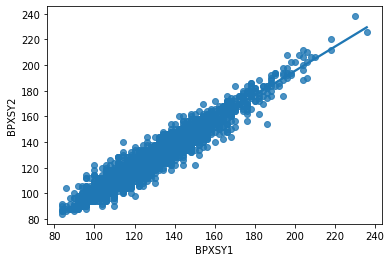

In [55]:
ax = sns.regplot(x='BPXSY1',y='BPXSY2',data=da)

In [73]:
df_sys = da[['BPXSY1','BPXSY2']].copy()
df_sys.dropna(subset=['BPXSY1','BPXSY2'],axis=0,inplace=True)
sys1_mean_ci = sm.stats.DescrStatsW(df_sys['BPXSY1'])#.zconfint_mean()
sys2_mean_ci = sm.stats.DescrStatsW(df_sys['BPXSY2'])#.zconfint_mean()
print('CI for syst pressure 1:',sys1_mean_ci.zconfint_mean(),'\nCI for syst pressure 2:',sys2_mean_ci.zconfint_mean())
print('CI for the difference:',sm.stats.CompareMeans(sys1_mean_ci,sys2_mean_ci).zconfint_diff())

CI for syst pressure 1: (124.59378718804363, 125.5831545143218) 
CI for syst pressure 2: (123.92688534371334, 124.90008429681563)
CI for the difference: (-0.018909477898866878, 1.3688815397353347)


__Q5a.__ Based on these confidence intervals, would you say that a difference of zero between the population mean values of the first and second systolic blood pressure measures is consistent with the data?

__Q5b.__ Discuss how the width of the confidence interval for the within-subject difference compares to the widths of the confidence intervals for the first and second measures.

## Question 6

Construct a 95% confidence interval for the mean difference between the average age of a smoker, and the average age of a non-smoker.

In [79]:
df_smk = da[['SMQ020','RIDAGEYR']].copy()
df_smk['Smoker'] = np.where(df_smk['SMQ020']==1,1,0)
df_smk.drop(columns='SMQ020',inplace=True)
df_smk.rename(columns={'RIDAGEYR':'Age'},inplace=True)
df_smk

,Age,Smoker
0,62,1
1,53,1
2,78,1
3,56,0
4,42,0
...,...,...
5730,76,1
5731,26,0
5732,80,1
5733,35,1


In [99]:
avgage_nonsmkr_ci = sm.stats.DescrStatsW(df_smk[df_smk['Smoker']==0]['Age'])
avgage_smkr_ci = sm.stats.DescrStatsW(df_smk[df_smk['Smoker']==1]['Age'])
print('CI for average age of non smokers:\t', avgage_nonsmkr_ci.zconfint_mean())
print('CI for average age of smokers:\t\t', avgage_smkr_ci.zconfint_mean())
print('CI for the difference:\t\t\t',sm.stats.CompareMeans(avgage_smkr_ci,avgage_nonsmkr_ci).zconfint_diff())

CI for average age of non smokers:	 (44.68411549118788, 45.929467646985415)
CI for average age of smokers:		 (51.38591951147112, 52.80726720694198)
CI for the difference:			 (5.833764359191363, 7.745839221048442)


__Q6a.__ Use graphical and numerical techniques to compare the variation in the ages of smokers to the variation in the ages of non-smokers.  

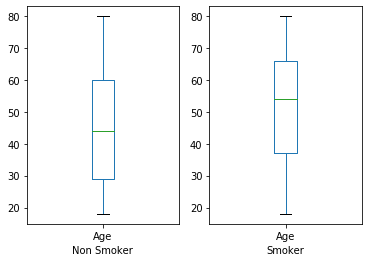

In [108]:
# insert your code here
fig=plt.figure()
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

df_smk[df_smk['Smoker']==0]['Age'].plot(kind='box',ax=ax0)
df_smk[df_smk['Smoker']==1]['Age'].plot(kind='box',ax=ax1)

ax0.set_xlabel('Non Smoker')
ax1.set_xlabel('Smoker')

plt.show()

__Q6b.__ Does it appear that uncertainty about the mean age of smokers, or uncertainty about the mean age of non-smokers contributed more to the uncertainty for the mean difference that we are focusing on here?